In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from matplotlib import pyplot as plt

import copy
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

# print(type(foreground_classes))

dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    
  

Files already downloaded and verified
Files already downloaded and verified


In [4]:
fg1, fg2, fg3 = 0,1,2

In [5]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [6]:
foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

(torch.Size([15000, 3, 32, 32]),
 torch.Size([15000]),
 torch.Size([35000, 3, 32, 32]),
 torch.Size([35000]))

In [7]:
mean_bg = torch.mean(background_data, dim=0, keepdims= True)
std_bg = torch.std(background_data, dim=0, keepdims= True)

In [8]:
mean_bg.shape, std_bg.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 32, 32]))

In [9]:
foreground_data = (foreground_data - mean_bg) / std_bg
background_data = (background_data - mean_bg) / std_bg

In [10]:
foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

(torch.Size([15000, 3, 32, 32]),
 torch.Size([15000]),
 torch.Size([35000, 3, 32, 32]),
 torch.Size([35000]))

In [11]:
torch.sum(torch.isnan(foreground_data)), torch.sum(torch.isnan(background_data))

(tensor(0), tensor(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


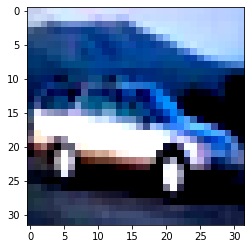

In [12]:
imshow(foreground_data[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


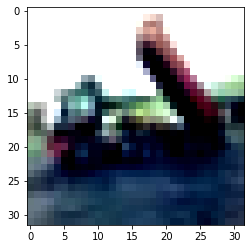

In [13]:
imshow(background_data[2])

In [14]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [15]:
desired_num = 20000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [16]:
print(len(mosaic_list_of_images) , len(mosaic_label), len(mosaic_list_of_images[0:10000]))
print(len(fore_idx))

20000 20000 10000
20000


In [17]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([3, 32,32], dtype=torch.float64)
    for j in range(9):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index
        
  

In [18]:
mosaic_list_of_images = torch.stack(mosaic_list_of_images)
mosaic_list_of_images.shape

torch.Size([20000, 9, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


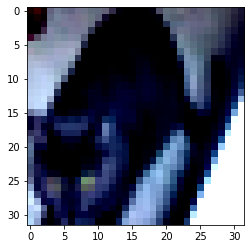

In [19]:
imshow(mosaic_list_of_images[0][2])

In [20]:
mean_train = torch.mean(mosaic_list_of_images[0:10000], dim=0, keepdims= True)
std_train = torch.std(mosaic_list_of_images[0:10000], dim=0, keepdims= True) 
mosaic_list_of_images = (mosaic_list_of_images - mean_train) / std_train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


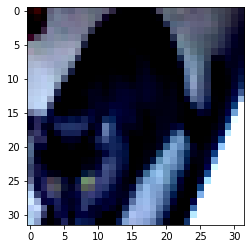

In [21]:
imshow(mosaic_list_of_images[0][2])

In [22]:
avg_image_dataset_0 , labels_0,  fg_index_0 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 0)
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 1)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 3)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 4)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 5)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 6)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 7)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 8)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 9)

test_dataset_10 , labels_10 , fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[10000:20000], mosaic_label[10000:20000], fore_idx[10000:20000] , 9)

# avg_image_dataset_1 = torch.stack(avg_image_dataset_1)
# avg_image_dataset_2 = torch.stack(avg_image_dataset_2)
# avg_image_dataset_3 = torch.stack(avg_image_dataset_3)
# avg_image_dataset_4 = torch.stack(avg_image_dataset_4)
# avg_image_dataset_5 = torch.stack(avg_image_dataset_5)
# avg_image_dataset_6 = torch.stack(avg_image_dataset_6)
# avg_image_dataset_7 = torch.stack(avg_image_dataset_7)
# avg_image_dataset_8 = torch.stack(avg_image_dataset_8)
# avg_image_dataset_9 = torch.stack(avg_image_dataset_9)
# test_dataset_10 = torch.stack(test_dataset_10)

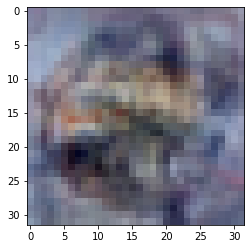

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


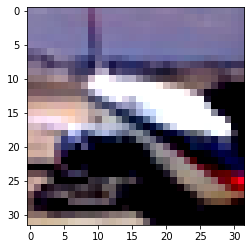

(None, None)

In [23]:
imshow(avg_image_dataset_1[0]), imshow(avg_image_dataset_9[0])

In [24]:
# mean_train = torch.mean(avg_image_dataset_1, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_1, dim=0, keepdims= True) 
# avg_image_dataset_1 = (avg_image_dataset_1 - mean_train) / std_train
# avg_image_dataset_1_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_2, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_2, dim=0, keepdims= True) 
# avg_image_dataset_2 = (avg_image_dataset_2 - mean_train) / std_train
# avg_image_dataset_2_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_3, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_3, dim=0, keepdims= True) 
# avg_image_dataset_3 = (avg_image_dataset_3 - mean_train) / std_train
# avg_image_dataset_3_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_4, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_4, dim=0, keepdims= True) 
# avg_image_dataset_4 = (avg_image_dataset_4 - mean_train) / std_train
# avg_image_dataset_4_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_5, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_5, dim=0, keepdims= True) 
# avg_image_dataset_5 = (avg_image_dataset_5 - mean_train) / std_train
# avg_image_dataset_5_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_6, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_6, dim=0, keepdims= True) 
# avg_image_dataset_6 = (avg_image_dataset_6 - mean_train) / std_train
# avg_image_dataset_6_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_7, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_7, dim=0, keepdims= True) 
# avg_image_dataset_7 = (avg_image_dataset_7 - mean_train) / std_train
# avg_image_dataset_7_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_8, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_8, dim=0, keepdims= True) 
# avg_image_dataset_8 = (avg_image_dataset_8 - mean_train) / std_train
# avg_image_dataset_8_test = (test_dataset_10 - mean_train) / std_train

# mean_train = torch.mean(avg_image_dataset_9, dim=0, keepdims= True)
# std_train = torch.std(avg_image_dataset_9, dim=0, keepdims= True) 
# avg_image_dataset_9 = (avg_image_dataset_9 - mean_train) / std_train
# avg_image_dataset_9_test = (test_dataset_10 - mean_train) / std_train

In [25]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [35]:
batch = 250

traindata_0 = MosaicDataset(avg_image_dataset_0, labels_0 )
trainloader_0 = DataLoader( traindata_0 , batch_size= batch ,shuffle=True)

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

In [36]:
testdata_0 = MosaicDataset(avg_image_dataset_0, labels_0 )
testloader_0 = DataLoader( testdata_0 , batch_size= batch ,shuffle=False)

testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(test_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

In [37]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
        torch.nn.init.xavier_normal_(self.conv.weight)
        torch.nn.init.zeros_(self.conv.bias)
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [38]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)

        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [39]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
        
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [40]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(3,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(236,3)
        torch.nn.init.xavier_normal_(self.linear.weight)
        torch.nn.init.zeros_(self.linear.bias)
        
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear(x) 
        return x

In [41]:
def test_all(number, testloader,inc):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= inc(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test dataset %d: %d %%' % (number , 100 * correct / total))

In [51]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    inc = inception_net().double()
    inc = inc.to("cuda")
    
    criterion_inception = nn.CrossEntropyLoss()
    optimizer_inception = optim.Adam(inc.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 100
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_inception.zero_grad()

            # forward + backward + optimize
            outputs = inc(inputs)
            loss = criterion_inception(outputs, labels)
            loss.backward()
            optimizer_inception.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 10))
                ep_lossi.append(running_loss/10) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
        print("Epoch_Loss: ",np.round(np.mean(ep_lossi),5))
        if(np.mean(ep_lossi) <= 0.005):
          break



    print('Finished Training')
    # torch.save(inc.state_dict(),"/content/drive/My Drive/Research/Experiments on CIFAR mosaic/Exp_2_Attention_models_on_9_datasets_made_from_10k_mosaic/weights/train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = inc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,inc)
    
    print("--"*40)
    
    return loss_curi
    

In [52]:
train_loss_all=[]

testloader_list= [ testloader_0, testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10]

train_loss_all.append(train_all(trainloader_0, 0, testloader_list))
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))

--------------------------------------------------------------------------------
training on data set   0
[1,    10] loss: 1.187
[1,    20] loss: 1.130
[1,    30] loss: 1.125
[1,    40] loss: 1.112
Epoch_Loss:  1.13855
[2,    10] loss: 1.099
[2,    20] loss: 1.105
[2,    30] loss: 1.101
[2,    40] loss: 1.097
Epoch_Loss:  1.10062
[3,    10] loss: 1.088
[3,    20] loss: 1.091
[3,    30] loss: 1.092
[3,    40] loss: 1.094
Epoch_Loss:  1.09135
[4,    10] loss: 1.076
[4,    20] loss: 1.079
[4,    30] loss: 1.080
[4,    40] loss: 1.082
Epoch_Loss:  1.07908
[5,    10] loss: 1.059
[5,    20] loss: 1.070
[5,    30] loss: 1.079
[5,    40] loss: 1.078
Epoch_Loss:  1.0717
[6,    10] loss: 1.058
[6,    20] loss: 1.057
[6,    30] loss: 1.055
[6,    40] loss: 1.039
Epoch_Loss:  1.05219
[7,    10] loss: 1.005
[7,    20] loss: 0.999
[7,    30] loss: 1.039
[7,    40] loss: 1.044
Epoch_Loss:  1.02158
[8,    10] loss: 0.972
[8,    20] loss: 0.948
[8,    30] loss: 0.958
[8,    40] loss: 0.992
Epoch_Loss: 

In [53]:
%matplotlib inline

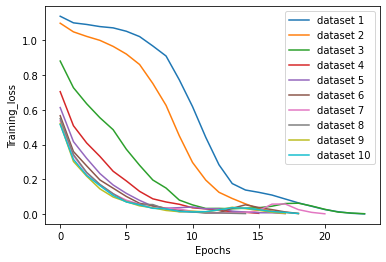

In [54]:
fig = plt.figure()
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend()
fig.savefig("Figure.pdf")